In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import pickle

c:\Users\haeun\anaconda3\envs\pytorch_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\haeun\anaconda3\envs\pytorch_nlp\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\haeun\anaconda3\envs\pytorch_nlp\lib\site-package

In [82]:
def preprocess(num,df):
    
    df_cleaned = df.dropna(subset=['overview'])
    unique_title = df_cleaned['title'].drop_duplicates()  
    sampled_title = unique_title.sample(num, replace=False, random_state=42)
    df_sampled = df_cleaned[df_cleaned['title'].isin(sampled_title)].drop_duplicates(subset='title')
    return df_sampled


In [83]:
df=pd.read_csv("TMDB movie dataset.csv")
df=preprocess(30000,df)

In [85]:

#set the device
device='cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [86]:
class MovieDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.bert_model = bert_model
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        tokenized = self.tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        return tokenized['input_ids'].squeeze(0), tokenized['attention_mask'].squeeze(0)


In [87]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from tqdm import tqdm

class BERT_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(BERT_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  
        output = self.fc(lstm_out)
        return output


lstm_model = BERT_LSTM(input_size=768, hidden_size=128, output_size=128).to(device)




In [88]:
def generate_embeddings_lstm_bert(texts,tokenizer,bert_model,lstm_model ,batch_size):
    dataset = MovieDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    embeddings = []
    for input_ids, attention_mask in tqdm(dataloader):
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        with torch.no_grad():
            bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            bert_embeddings = bert_outputs.last_hidden_state.mean(dim=1)
            lstm_embeddings = lstm_model(bert_embeddings.unsqueeze(1))
        embeddings.append(lstm_embeddings.cpu().numpy())
    
    return np.vstack(embeddings)

df

In [89]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
valid_overviews = df['overview'].dropna().tolist()
plot_embeddings = generate_embeddings_lstm_bert(valid_overviews,tokenizer,bert_model,lstm_model,batch_size=32)

100%|██████████| 938/938 [08:53<00:00,  1.76it/s]


In [90]:
df['embedding']=None
df['embedding']=list(plot_embeddings)


In [91]:
# Genres Encoding
mlb_genres = MultiLabelBinarizer()
df['genres'] = df['genres'].fillna('').apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)
genres_encoded = mlb_genres.fit_transform(df['genres'])

#Production Companies Encoding
mlb_companies = MultiLabelBinarizer()
df['production_companies'] = df['production_companies'].fillna('').apply(lambda x: [production_company.strip() for production_company in x.split(',')] if isinstance(x,str) else x)  
companies_encoded = mlb_companies.fit_transform(df['production_companies'])

# Keywords Encoding
mlb_keywords = MultiLabelBinarizer()
df['keywords'] = df['keywords'].fillna('').apply(lambda x: [keyword.strip() for keyword in x.split(',')] if isinstance(x,str) else x)
keywords_encoded = mlb_keywords.fit_transform(df['keywords'])

In [92]:
genres_list=list(mlb_genres.classes_)
company_list=list(mlb_companies.classes_)
production_list=list(mlb_companies.classes_)
keyword_list=list(mlb_keywords.classes_)

movie_embeddings = []

for index, row in tqdm(df.iterrows()):
    movie = {}
    
    # Genres Extraction
    query_genres = [genre for genre in genres_list if genre.lower() in " ".join(row["genres"]).lower()]
    
    movie["genres"] = np.sum(mlb_genres.transform([query_genres]), axis=0) if query_genres else np.zeros(len(mlb_genres.classes_))

    query_companies = [company for company in company_list if company.lower() in " ".join(row["production_companies"]).lower()]
    
    movie["companies"] = np.sum(mlb_companies.transform([query_companies]), axis=0) if query_companies else np.zeros(len(mlb_companies.classes_))

    # Keywords Extraction
    query_keywords = [keyword for keyword in keyword_list if keyword.lower() in " ".join(row["keywords"]).lower()]
    movie["keywords"] = np.sum(mlb_keywords.transform([query_keywords]), axis=0) if query_keywords else np.zeros(len(mlb_keywords.classes_))
    
    embedding_array = np.array(row['embedding'])
    movie["overview"] = embedding_array
    movie_embeddings.append(movie)

   

30000it [23:54, 20.92it/s]


In [93]:

def generate_query_embedding(query, tokenizer, bert_model, lstm_model, genres_list, company_list):
   
    query_embedding = {}

    # Genres Extraction    
    query_genres = [genre for genre in genres_list if genre.lower() in query.lower()]
    query_embedding["genres"] = np.sum(mlb_genres.transform([query_genres]), axis=0) if query_genres else np.zeros(len(mlb_genres.classes_))

    #Companies Extraction
    query_companies = [company for company in company_list if company.lower() in query.lower()]
    query_embedding["companies"] = np.sum(mlb_companies.transform([query_companies]), axis=0) if query_companies else np.zeros(len(mlb_companies.classes_))
    
    # Keywords Extraction
    query_keywords = query.split()  
    query_embedding["keywords"] = np.sum(mlb_keywords.transform([query_keywords]), axis=0) if query_keywords else np.zeros(len(mlb_keywords.classes_))

    # Overview Embedding (BERT + LSTM)
    query_embedding["overview"] = generate_embeddings_lstm_bert([query], tokenizer, bert_model, lstm_model, batch_size=1).flatten()

    return query_embedding


In [94]:
from scipy.spatial.distance import euclidean

from sklearn.preprocessing import MinMaxScaler


def calculate_similarity(query_embedding, movie_embeddings, weights):
    scaler=MinMaxScaler()
    similarity_scores = []
    
    for movie in movie_embeddings:
        movie['genres'] = scaler.fit_transform(movie['genres'].reshape(-1, 1)).flatten()  
        movie['companies'] = scaler.fit_transform(movie['companies'].reshape(-1, 1)).flatten()
        movie['keywords'] = scaler.fit_transform(movie['keywords'].reshape(-1, 1)).flatten()
        movie['overview'] = scaler.fit_transform(movie['overview'].reshape(-1, 1)).flatten()


    query_embedding['genres'] = scaler.transform(query_embedding['genres'].reshape(-1, 1)).flatten()
    query_embedding['companies'] = scaler.transform(query_embedding['companies'].reshape(-1, 1)).flatten()
    query_embedding['keywords'] = scaler.transform(query_embedding['keywords'].reshape(-1, 1)).flatten()
    query_embedding['overview'] = scaler.transform(query_embedding['overview'].reshape(-1, 1)).flatten()
    for movie in movie_embeddings:
       
        genres_sim= 0 if weights['genres']==0 else cosine_similarity([query_embedding["genres"]], [movie["genres"]])[0][0]
        companies_sim = 0 if weights['companies']==0 else cosine_similarity([query_embedding["companies"]], [movie["companies"]])[0][0]
        keywords_sim = 0 if weights['keywords'] == 0 else cosine_similarity([query_embedding["keywords"]], [movie["keywords"]])[0][0]
        overview_sim =0 if weights['overview']==0 else  cosine_similarity([query_embedding["overview"]], [movie["overview"]])[0][0]

       
        # Weighted Sum of Similarities
        genres_sim_euclid =0 if weights['genres'] ==0 else  1/(1+euclidean(query_embedding["genres"], movie["genres"]))
        companies_sim_euclid = 0 if weights['companies'] == 0 else 1 / (1 + euclidean(query_embedding["companies"], movie["companies"]))
        keywords_sim_euclid=0 if weights['keywords']==0 else 1/(1+euclidean(query_embedding["keywords"], movie["keywords"]))
        overview_sim_euclid=0 if weights['overview']==0 else 1/(1+euclidean(query_embedding["overview"], movie["overview"]))
           
     
        
        total_similarity = (
            weights["genres"] * (genres_sim + genres_sim_euclid) +
            weights["companies"] * (companies_sim + companies_sim_euclid) +
            weights["keywords"] * (keywords_sim + keywords_sim_euclid) +
            +weights["overview"] * (overview_sim + overview_sim_euclid)
        )
       
        
        similarity_scores.append(total_similarity)
    return similarity_scores


In [95]:

def recommend_movies(query, df, embeddings, tokenizer, bert_model, lstm_model, weights,top_n=10):
    
    genres_list=list(mlb_genres.classes_)
    company_list=list(mlb_companies.classes_)
    
    query_embedding = generate_query_embedding(query, tokenizer, bert_model, lstm_model, genres_list, company_list)
    
     
    similarity_scores = calculate_similarity(query_embedding, embeddings, weights)
    df["similarity"] = similarity_scores
    recommended_movies = df.sort_values(by="similarity", ascending=False).head(top_n)
    remaining_movies = df.drop(recommended_movies.index)
    randomly_selected_movies=remaining_movies.sample(10)
    random_movie_titles=randomly_selected_movies['title']
   
    recommended_movie_titles = recommended_movies["title"].values
    recommended_movie_embeddings = [embedding for idx, embedding in enumerate(embeddings) if df.iloc[idx]["title"] in recommended_movie_titles]
    random_movie_titles=randomly_selected_movies['title'].values
    
    randomly_selected_movies=[embedding for idx, embedding in enumerate(embeddings) if df.iloc[idx]["title"] in random_movie_titles]
   
    visualize_sne(recommended_movie_embeddings,query_embedding,randomly_selected_movies,recommended_movie_titles,random_movie_titles)
    return recommended_movies[["title", "genres", "similarity",'overview']]



In [96]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_sne(movie_embeddings, query_embedding,randomly_selected_movie,recommended_movie_titles,random_movie_titles):
    
    
    movie_num=len(movie_embeddings)
  
    query_embedding = np.array(query_embedding['overview']).reshape(1, -1)
    movie_embeddings = np.array([embedding['overview'] for  embedding in movie_embeddings])  
    randomly_selected_movie=np.array([embedding['overview'] for embedding in randomly_selected_movie])  
    
    
    
    combined_embeddings = np.vstack([query_embedding, randomly_selected_movie,movie_embeddings])  

    # ->2dimension
    tsne = TSNE(n_components=2, random_state=42, perplexity=12, n_iter=1000,learning_rate=200)
    
    embeddings_2d = tsne.fit_transform(combined_embeddings)

    df_tsne = pd.DataFrame(embeddings_2d, columns=['tsne1', 'tsne2'])
    df_tsne['type'] = ['query'] + ['movie'] * len(movie_embeddings)  +['random'] * len(randomly_selected_movie)
    plt.scatter(df_tsne.iloc[:10, 0], df_tsne.iloc[:10, 1], label="Random Movies", color="blue", alpha=0.7)
    plt.scatter(df_tsne.iloc[10:15, 0], df_tsne.iloc[10:15, 1], label="Recommended Movies", color="red", alpha=0.7)
    plt.scatter(df_tsne.iloc[-1, 0], df_tsne.iloc[-1, 1], label="Query", color="green")

    for i, title in enumerate(random_movie_titles):
        plt.text(df_tsne.iloc[i, 0], df_tsne.iloc[i, 1], title, fontsize=5)
    for i, title in enumerate(recommended_movie_titles):
        plt.text(df_tsne.iloc[10 + i, 0], df_tsne.iloc[10 + i, 1], title, fontsize=5)
    plt.text(df_tsne.iloc[-1, 0], df_tsne.iloc[-1, 1], 'User input', fontsize=5)    
    plt.legend()
    plt.title('t-SNE Visualization of movies(TMDB)', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()



c:\Users\haeun\anaconda3\envs\pytorch_nlp\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['British', 'Murder', 'Mystery', 'from', 'scottland', 'with', 'yard?'] will be ignored
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


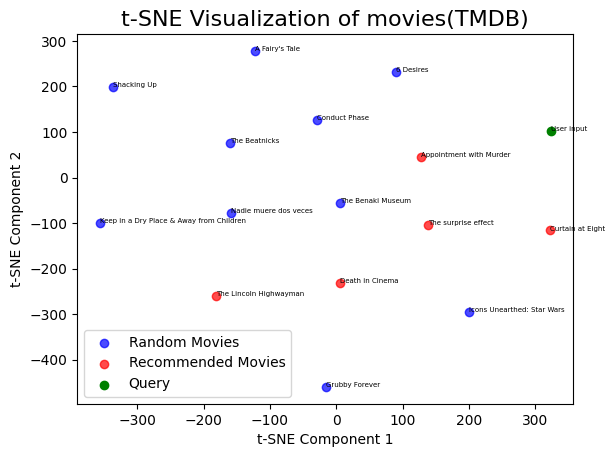

                          title     genres  similarity  \
109152         Curtain at Eight  [Mystery]    0.950747   
132116  Appointment with Murder  [Mystery]    0.947658   
886099          Death in Cinema  [Mystery]    0.944472   
884191   The Lincoln Highwayman  [Mystery]    0.943512   
636367      The surprise effect  [Mystery]    0.942002   

                                                 overview  
109152  An elderly detective sets out to find who murd...  
132116  The second Falcon film to feature actor/magici...  
886099  Ex-Gulag prison guard investigates murder on t...  
884191  Marian Calvert becomes infatuated with the inf...  
636367  Raúl and Héctor relax on the roof. Part of the...  


In [97]:
query = "British Murder Mystery with detective from scottland yard?"

weights = {"genres": 0.6, "companies": 0.1, "keywords": 0.1, "overview": 0.2} 
recommendations = recommend_movies(query, df, movie_embeddings, tokenizer, bert_model, lstm_model, weights,top_n=5)

print(recommendations)